<a href="https://colab.research.google.com/github/k-chanez/Churn-prediction/blob/dev_amel/Churn_prediction_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google-cloud-bigquery


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score , confusion_matrix , classification_report
from sklearn.model_selection import GridSearchCV, cross_validate

In [ ]:
# Set the path to your service account key file on the GCE VM
key_path = "/projet-m2-ia-churn-prediction-db53d6498522.json"

# Set the environment variable for authentication
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

In [ ]:
from google.cloud import bigquery

# Remplacez 'project_id' par l'ID de votre projet GCP
project_id = 'projet-m2-ia-churn-prediction'

# Exécutez une requête BigQuery
query = """
SELECT *
FROM `projet-m2-ia-churn-prediction.Ecommerce_Churn.Ecommerce_Table1`"""
df = bigquery.Client(project=project_id).query(query).to_dataframe()

# Affichez le résultat
print(df)


      CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  \
0          52720      0    60.0         Mobile Phone         3   
1          50929      0    50.0         Mobile Phone         1   
2          53744      0    51.0         Mobile Phone         1   
3          55535      0    61.0         Mobile Phone         3   
4          51851      0     0.0         Mobile Phone         1   
...          ...    ...     ...                  ...       ...   
5054       53361      0     1.0         Mobile Phone         1   
5055       54286      0     1.0         Mobile Phone         1   
5056       54165      0     1.0         Mobile Phone         1   
5057       53354      1     1.0         Mobile Phone         1   
5058       54824      1     1.0         Mobile Phone         1   

      WarehouseToHome PreferredPaymentMode  Gender  HourSpendOnApp  \
0                27.0           Debit Card  Female             3.0   
1                 6.0           Debit Card    Male             3.0 

In [ ]:
df.shape

(5366, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5366 entries, 0 to 5365
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5366 non-null   Int64  
 1   Churn                        5366 non-null   Int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5366 non-null   object 
 4   CityTier                     5366 non-null   Int64  
 5   WarehouseToHome              5115 non-null   float64
 6   PreferredPaymentMode         5366 non-null   object 
 7   Gender                       5366 non-null   object 
 8   HourSpendOnApp               5111 non-null   float64
 9   NumberOfDeviceRegistered     5366 non-null   Int64  
 10  PreferedOrderCat             5366 non-null   object 
 11  SatisfactionScore            5366 non-null   Int64  
 12  MaritalStatus                5366 non-null   object 
 13  NumberOfAddress   

In [ ]:
df.nunique()

CustomerID                     5366
Churn                             2
Tenure                           36
PreferredLoginDevice              2
CityTier                          3
WarehouseToHome                  34
PreferredPaymentMode              5
Gender                            2
HourSpendOnApp                    6
NumberOfDeviceRegistered          6
PreferedOrderCat                  6
SatisfactionScore                 5
MaritalStatus                     3
NumberOfAddress                  14
Complain                          2
OrderAmountHikeFromlastYear      16
CouponUsed                       17
OrderCount                       16
DaySinceLastOrder                22
CashbackAmount                 2466
dtype: int64

In [ ]:
colonnes = list(df.columns)
print(colonnes)

['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier', 'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


In [ ]:
df.describe(include='O').style.background_gradient(axis=None , cmap = "Blues" , vmin = 0 , vmax = 9000  )

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5366,5366,5366,5366,5366
unique,2,5,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,3814,2208,3217,2039,2856


In [ ]:
for col in colonnes :
  if df[col].dtypes == 'object' :
    print('pour la colonnes: ', col)
    print(df[col].value_counts())
    print('------------------------------------')

pour la colonnes:  PreferredLoginDevice
Mobile Phone    3814
Computer        1552
Name: PreferredLoginDevice, dtype: int64
------------------------------------
pour la colonnes:  PreferredPaymentMode
Debit Card          2208
Credit Card         1686
E wallet             601
Cash on Delivery     480
UPI                  391
Name: PreferredPaymentMode, dtype: int64
------------------------------------
pour la colonnes:  Gender
Male      3217
Female    2149
Name: Gender, dtype: int64
------------------------------------
pour la colonnes:  PreferedOrderCat
Laptop & Accessory    2039
Mobile Phone          1227
Fashion                826
Mobile                 600
Grocery                410
Others                 264
Name: PreferedOrderCat, dtype: int64
------------------------------------
pour la colonnes:  MaritalStatus
Married     2856
Single      1699
Divorced     811
Name: MaritalStatus, dtype: int64
------------------------------------


In [ ]:
# recoder phone et mobile phone
df['PreferredLoginDevice'].replace('Phone', 'Mobile Phone', inplace = True)
df['PreferredLoginDevice'].value_counts()

Mobile Phone    3814
Computer        1552
Name: PreferredLoginDevice, dtype: int64

In [ ]:
# recoder cod et cash
#recoder cc et credit card
df['PreferredPaymentMode'].replace('COD','Cash on Delivery', inplace= True)
df['PreferredPaymentMode'].replace('CC','Credit Card', inplace= True)
df['PreferredPaymentMode'].value_counts()

Debit Card          2208
Credit Card         1686
E wallet             601
Cash on Delivery     480
UPI                  391
Name: PreferredPaymentMode, dtype: int64

In [ ]:
df.select_dtypes(include=np.number).columns

Index(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome',
       'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore',
       'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
       'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [ ]:
for col in colonnes:
  if df[col].dtypes =='float' or df[col].dtypes =='int':
    print('pour la colonne: ', col)
    print(df[col].value_counts())
    print('-------------------------------------------')

pour la colonne:  Tenure
1.0     690
0.0     508
8.0     263
9.0     247
7.0     221
10.0    213
5.0     204
4.0     203
3.0     195
11.0    194
6.0     183
12.0    182
13.0    181
14.0    176
2.0     167
15.0    159
16.0    149
19.0    140
18.0    123
20.0    109
17.0    106
23.0     89
21.0     84
22.0     76
24.0     75
28.0     70
30.0     66
27.0     66
26.0     60
25.0     59
29.0     55
31.0     49
60.0      1
50.0      1
51.0      1
61.0      1
Name: Tenure, dtype: int64
-------------------------------------------
pour la colonne:  WarehouseToHome
9.0      536
8.0      417
7.0      376
16.0     305
14.0     286
15.0     269
10.0     269
6.0      259
13.0     233
11.0     223
17.0     213
12.0     211
22.0     100
31.0      96
35.0      93
32.0      92
30.0      90
23.0      88
18.0      87
25.0      86
24.0      83
26.0      81
21.0      80
29.0      78
27.0      73
20.0      70
19.0      69
28.0      65
33.0      65
34.0      61
36.0      51
5.0        8
126.0      1
127.0    

In [ ]:
# Convertir num colonnes en categorie

df2 = df.copy()
for col in df2.columns :
  if col =='CustomerID':
    continue
  elif df2[col].dtypes =='int':
    df2[col]= df2[col].astype(str)

df2.dtypes

CustomerID                       Int64
Churn                            Int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         Int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         Int64
PreferedOrderCat                object
SatisfactionScore                Int64
MaritalStatus                   object
NumberOfAddress                  Int64
Complain                         Int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [ ]:
# colonnes Categorical  apres convertion
df2.describe(include='O').style.background_gradient(axis=None , cmap = "Blues" , vmin = 0 , vmax = 9000  )

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5366,5366,5366,5366,5366
unique,2,5,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,3814,2208,3217,2039,2856


In [ ]:
# colonnes  numeriques apres conversion
df2.describe().T.style.bar(subset=['mean']).background_gradient(subset=['std','50%','max'])

,count,mean,std,min,25%,50%,75%,max
CustomerID,5366.000000,52886.477637,1622.164976,50001.000000,51484.250000,52947.500000,54288.750000,55630.000000
Churn,5366.000000,0.161573,0.368093,0.000000,0.000000,0.000000,0.000000,1.000000
Tenure,5366.000000,10.189899,8.557241,0.000000,2.000000,9.000000,16.000000,61.000000
CityTier,5366.000000,1.666045,0.920873,1.000000,1.000000,1.000000,3.000000,3.000000
WarehouseToHome,5115.000000,15.697947,8.570674,5.000000,9.000000,14.000000,21.000000,127.000000
HourSpendOnApp,5111.000000,2.955586,0.722699,0.000000,2.000000,3.000000,3.000000,5.000000
NumberOfDeviceRegistered,5366.000000,3.710399,1.028028,1.000000,3.000000,4.000000,4.000000,6.000000
SatisfactionScore,5366.000000,3.058330,1.385637,1.000000,2.000000,3.000000,4.000000,5.000000
NumberOfAddress,5366.000000,4.268170,2.587053,1.000000,2.000000,3.000000,6.000000,22.000000
Complain,5366.000000,0.285688,0.451783,0.000000,0.000000,0.000000,1.000000,1.000000


In [ ]:
# verifier les duplicat
df.duplicated().sum()

0

In [ ]:
# la somme  et les pourcentage des valeurs manquantes  pour chaque colonnes
nan_info = []
for col in colonnes :
  val_miss = df[col].isnull().sum()
  pourcentage = val_miss /len(df) * 100
  nan_info.append([col , val_miss , pourcentage])


nan_info_df = pd.DataFrame(nan_info , columns=(['colonne', 'sum_nan', 'pourcentage']))
nan_info_df.head()

,colonne,sum_nan,pourcentage
0,CustomerID,0,0.0
1,Churn,0,0.0
2,Tenure,0,0.0
3,PreferredLoginDevice,0,0.0
4,CityTier,0,0.0


In [ ]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

# Data Exploration

In [ ]:
import plotly.graph_objects  as go
from plotly.subplots import make_subplots

colonne_cat_binaire = ['Complain']
target = ['Churn']
cat_colonnes = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode',
       'Gender', 'NumberOfDeviceRegistered', 'PreferedOrderCat',
       'SatisfactionScore', 'MaritalStatus', 'NumberOfAddress', 'Complain']
num_colonnes = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear',
                'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

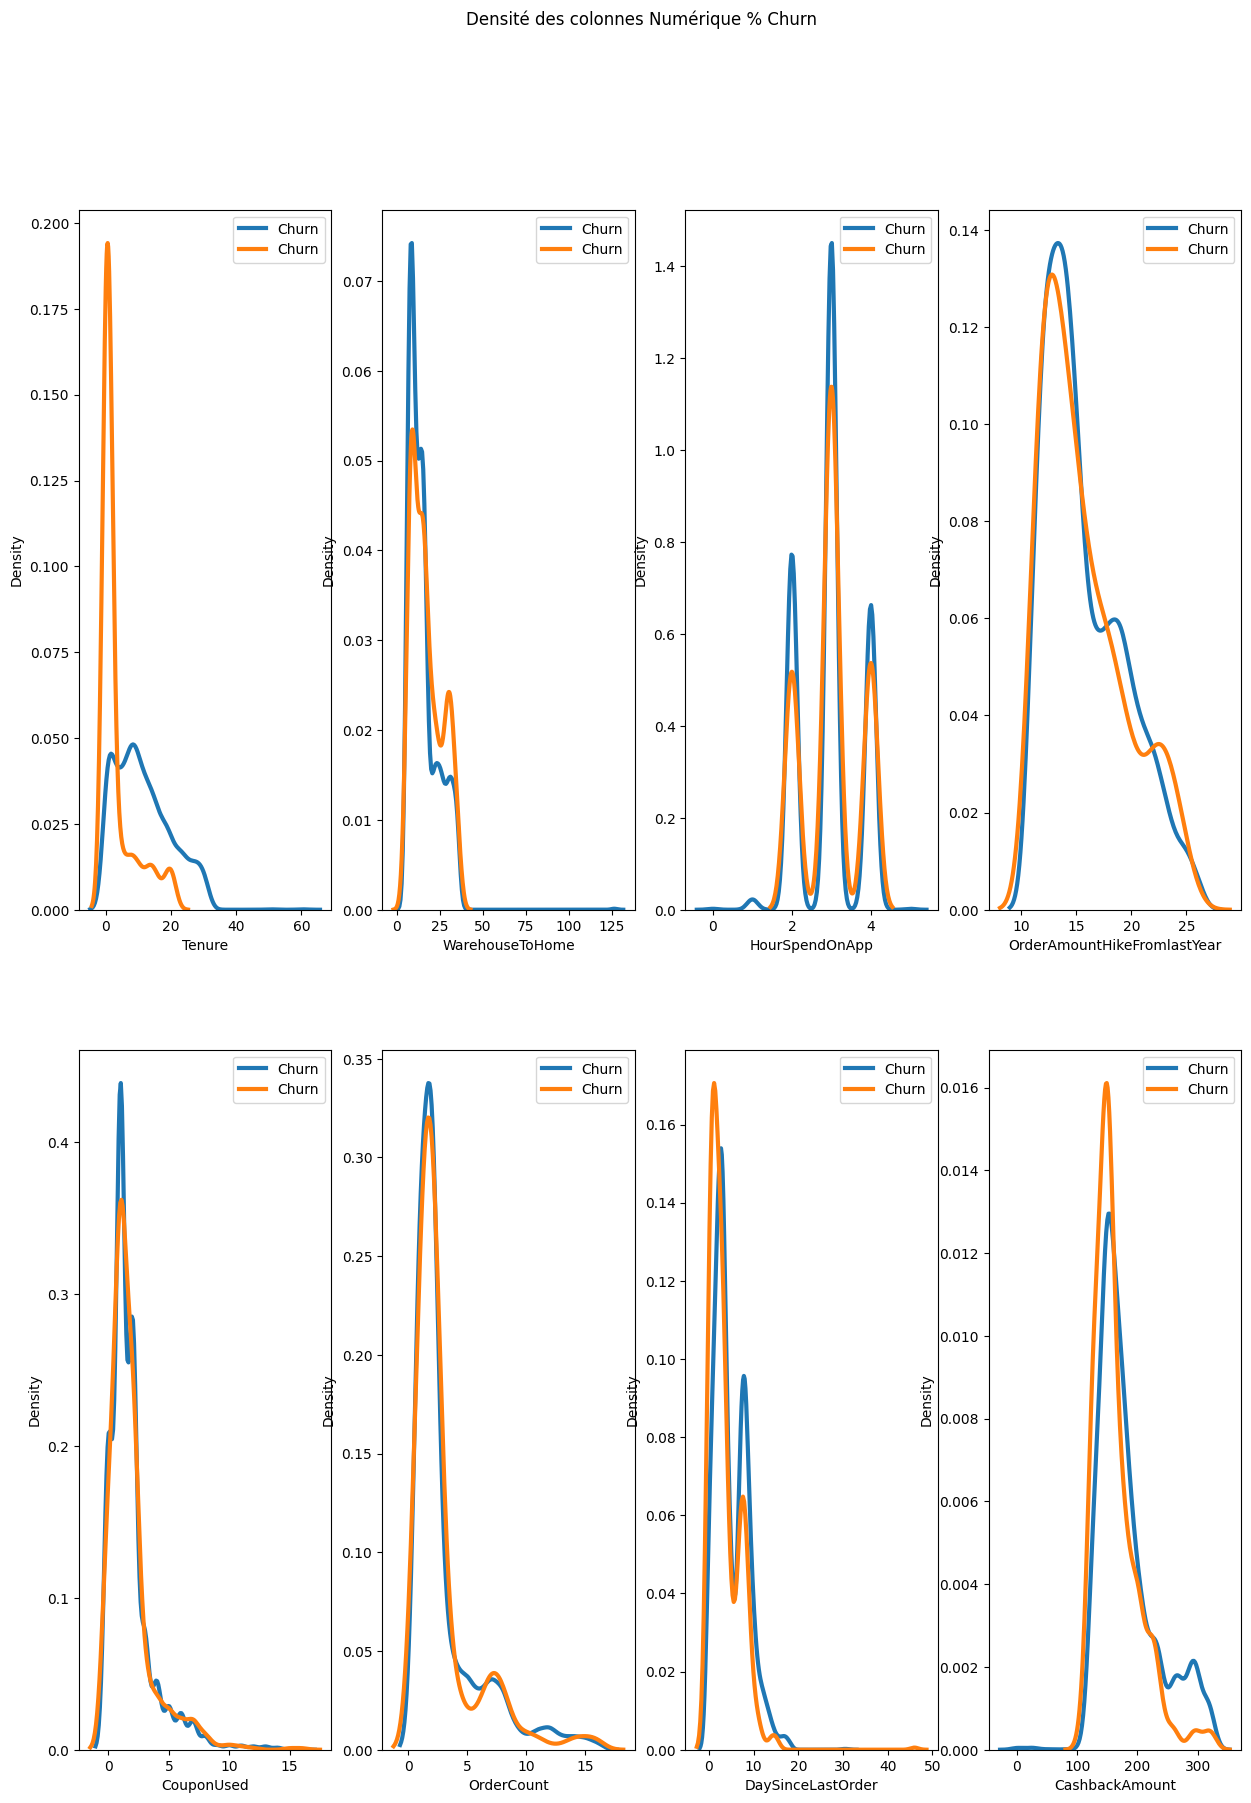

In [ ]:
# l'impact  des colonnes numérique sur la colonne target 'Churn'
df_c = df[df['Churn']==0]
df_nc = df[df['Churn']==1]

fig, ax= plt.subplots(2,4 , figsize=(15,20))
fig.suptitle('Densité des colonnes Numérique % Churn')
ax = ax.flatten()

for i, c in enumerate(num_colonnes):
    sn.kdeplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    sn.kdeplot(df_nc[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    ax[i].legend(loc='upper right')

plt.show()

# Analyses des distributions des caractéristiques numériques

- **Tenure (Ancienneté)** : Les clients avec une ancienneté plus longue semblent moins susceptibles de résilier leur abonnement. Cela a du sens car une anciennté plus longue indique une satisfaction.


- **CityTier (Niveau de la ville)** : Le taux de résiliation semble similaire entre les différents niveaux de ville. Le niveau de la ville ne semble pas être prédictif de la résiliation.


- **WarehouseToHome (Distance entre l'entrepôt et la maison)** : Les distances plus courtes entre l'entrepôt et la maison ont un taux de résiliation plus faible. Des livraisons plus rapides peuvent améliorer la satisfaction.


- **HourSpendOnApp (Heures passées sur l'application)** : passer plus du temps sur l'application est corrélé à une résiliation plus faible. Le temps passé sur l'application est un bon indicateur.


- **NumberOfDeviceRegistered (Nombre de dispositifs enregistrés)** : plus le nombre de dispositifs enregistrés  est élevé plus la résiliation est faible. L'accès sur plusieurs dispositifs améliore la fidélité.


- **SatisfactionScore (Score de satisfaction)** : Des scores de satisfaction plus élevés sont fortement associés à une résiliation plus faible, comme prévu. Un élément clé.


- **NumberOfAddress (Nombre d'adresses)** :plus une personne a d'adresses enregistrées, moins elle est susceptible de résilier. Cela suggère que les clients avec plus d'adresses sont généralement plus fidèles.


- **Complaint (Réclamation)** : Plus de réclamations sont associées à une résiliation plus élevée, Les réclamations nuisent à la satisfaction.


- **OrderAmountHikeFromLastYear (Augmentation du montant de la commande depuis l'année dernière)** : Les clients ayant dépensé davantage l'année dernière sont moins susceptibles de résilier. Bon pour fidéliser les gros clients.


- **CouponUsed (Utilisation de coupons)** : L'utilisation de coupons est corrélée à une résiliation plus faible. Les coupons renforcent la fidélité.


- **OrderCount (Nombre de commandes)** : Un nombre élevé de commandes est associé à une résiliation plus faible. Une utilisation fréquente construit des habitudes.


- **DaySinceLastOrder (Jours depuis la dernière commande)** : Un laps de temps plus long depuis la dernière commande est corrélé à une résiliation plus élevée. La récence est un bon prédicteur.

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning:

In a future version, the I

IndexError: ignored

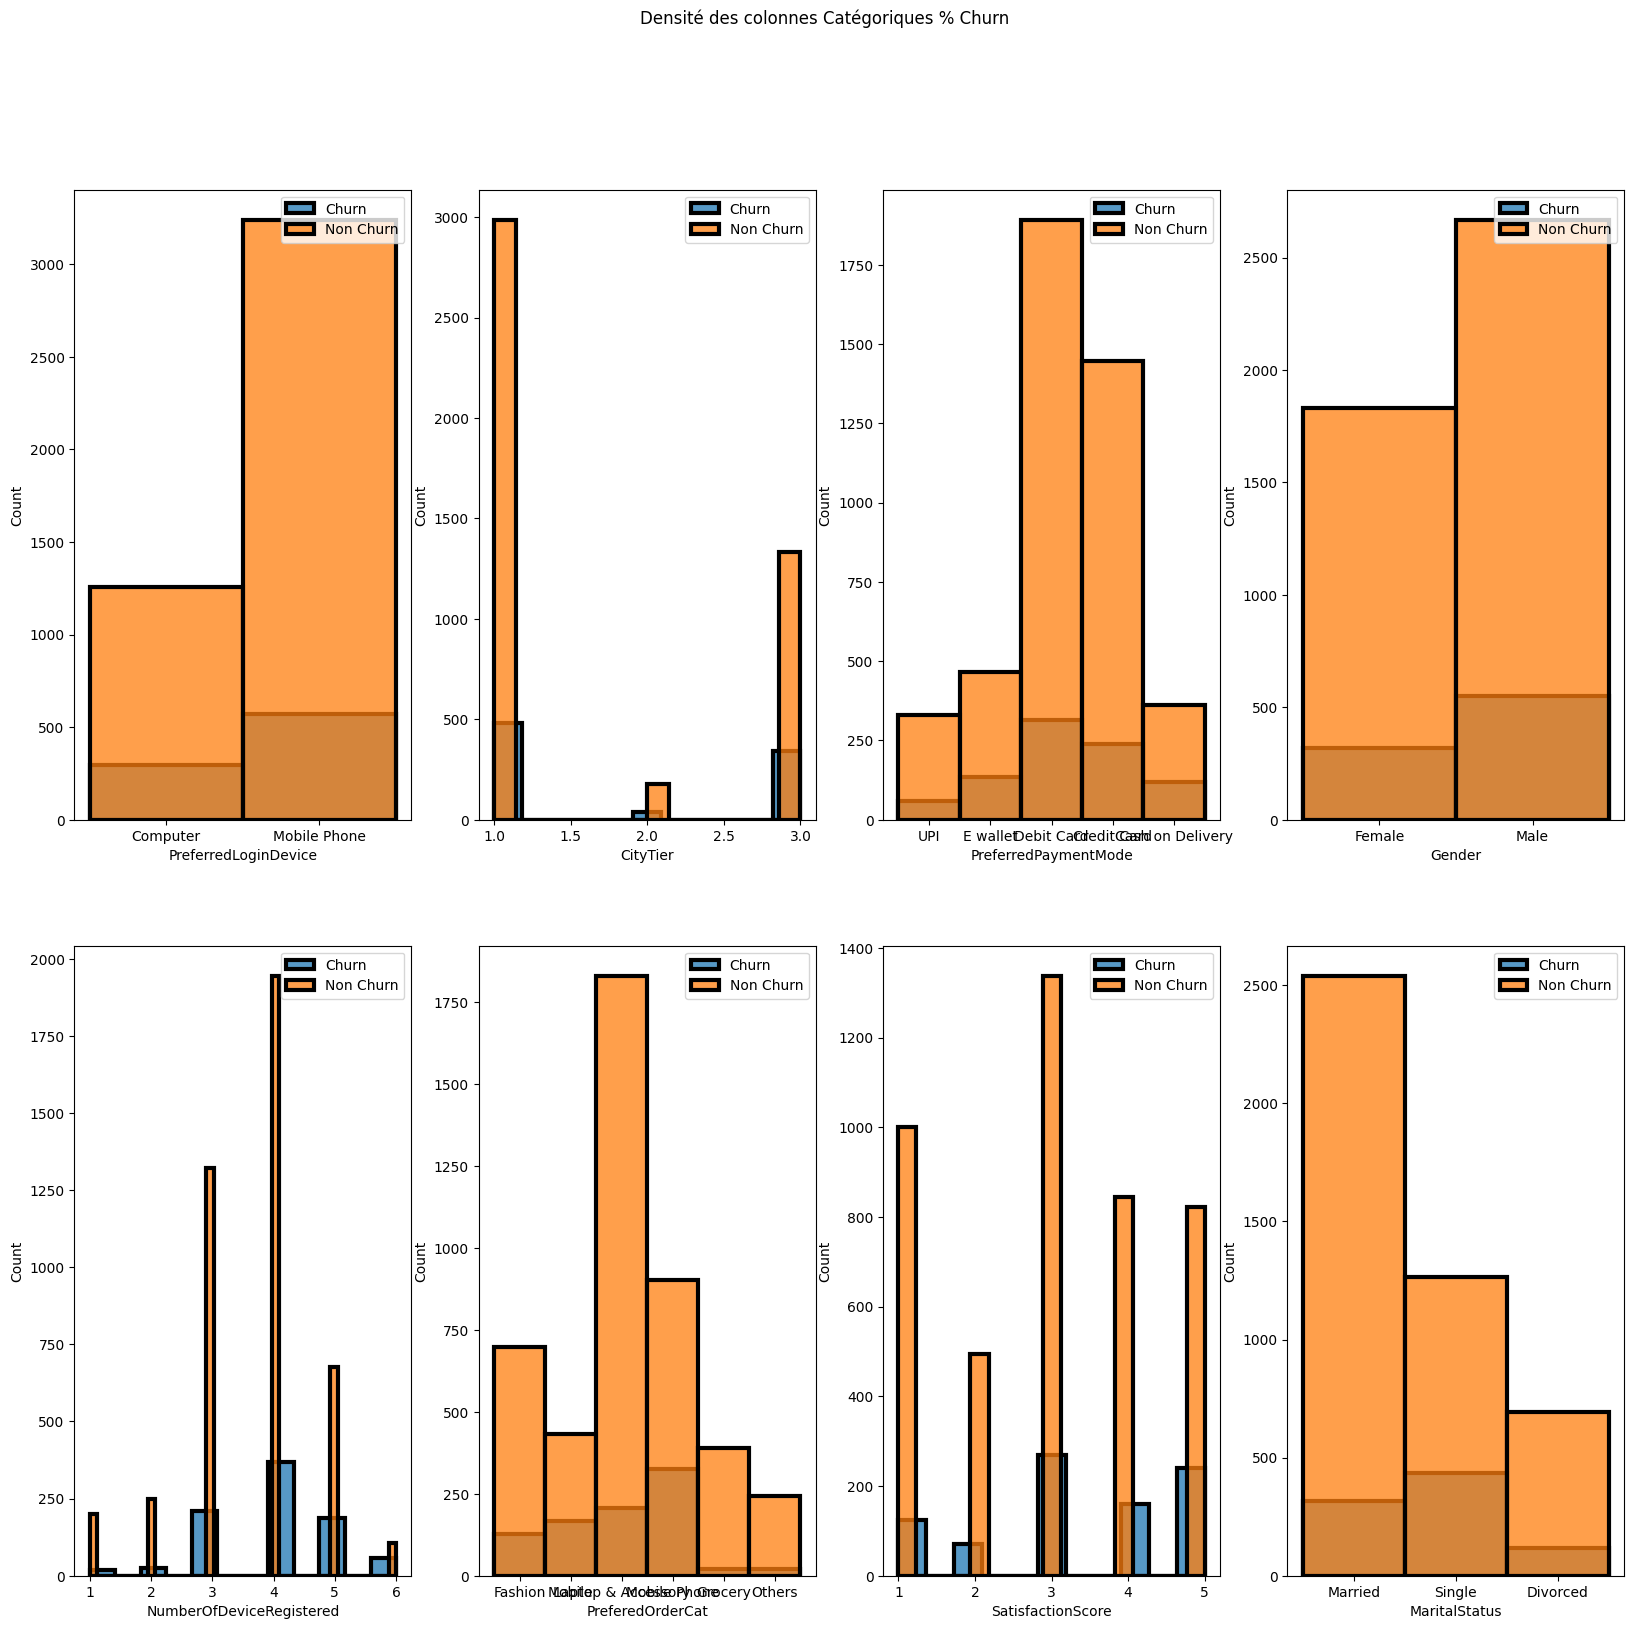

In [ ]:
# l'impact  des colonnes catégoricals sur la colonne target 'Churn'
df_c = df[df['Churn']==1]
df_nc = df[df['Churn']==0]

fig, ax= plt.subplots(2,4 , figsize=(20,18))
fig.suptitle('Densité des colonnes Catégoriques % Churn')
ax = ax.flatten()

for i, c in enumerate(cat_colonnes):
    sn.histplot(df_c[c], linewidth= 3,
             label = 'Churn',ax=ax[i])
    sn.histplot(df_nc[c], linewidth= 3,
             label = 'Non Churn',ax=ax[i])
    ax[i].legend(loc='upper right')

plt.show()

**Commentaire sur les graphes ** a refaiiiireeeeee j'ai mélanger

- **PrefferedLoginDevice (outis de connexion préféré)** :


- **PrefferedPayementMode (mode de paiement préféré)**: Le taux de churn le plus élevé est pour les clients qui utilisent le paiement Credit card et Debit Card. .


- **Gender (sexe) **: Le taux de churn est plus élevé pour les hommes que pour les femmes. Cela peut être dû à des facteurs tels que les besoins et les attentes différents des hommes et des femmes. L'entreprise peut cibler ses efforts de marketing et de vente sur les besoins et les intérêts spécifiques des hommes


- **MaritalStatus (statut matrimonial)** : Le taux de churn est plus élevé pour les Mariés que pour les personnes Célibataires ou divorcées.


- **PrefferedOrder (catégorie de commande préférée)**: Le taux de churn est plus élevé pour les clients qui commandent des produits électroniques. Cela peut être dû au fait que les produits électroniques sont souvent plus chers et plus complexes que d'autres produits.l'entreprise peut fournir un meilleur support client et des garanties plus longues




Voir si ya une relation entre le genre et le churn

In [ ]:
df['Gender'].value_counts()

Male      3217
Female    2149
Name: Gender, dtype: int64

In [ ]:
df.groupby('Churn')['Gender'].value_counts()

Churn  Gender
0      Male      2668
       Female    1831
1      Male       549
       Female     318
Name: Gender, dtype: int64

In [ ]:
femal_churn_rate = round(348/1898 * 100, 2)
mal_churn_rate = round(600/2784 *100,2)
print( 'Femal churn rate :', femal_churn_rate,'%')
print( 'Mal churn rate :', mal_churn_rate,'%')

Femal churn rate : 18.34 %
Mal churn rate : 21.55 %


<Axes: xlabel='Gender'>

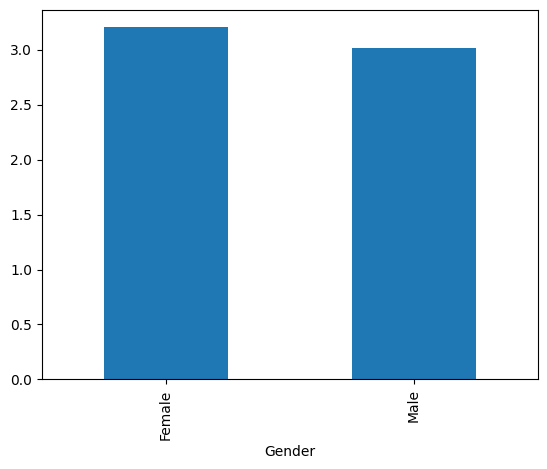

In [ ]:
gender_orders = df.groupby('Gender')['OrderCount'].mean().plot(kind='bar')

gender_orders

In [ ]:
import plotly.express as px

fig = px.pie(df, values='Churn', names='Gender')
fig.update_traces(marker=dict(colors=['pink ', 'baby blue']))
fig.update_layout(
  title='Churn % Genre',
  legend_title='Genre'
)

fig.show()

Comme nous pouvons le constater, les hommes ont plus de chances de résilier, avec 63,3 % de résiliations parmi les utilisateurs masculins de l'application. Peut-être que l'entreprise devrait envisager d'augmenter le nombre de produits susceptibles d'intéresser les hommes.

Nous allons examiner s'il existe d'autres facteurs expliquant pourquoi le segment le plus important de clients résiliés est constitué d'hommes.

# Quelle situation familliale à le taux le plus élevé de churn ?

In [ ]:
df.groupby('Churn')['MaritalStatus'].value_counts()

Churn  MaritalStatus
0      Married          2540
       Single           1264
       Divorced          695
1      Single            435
       Married           316
       Divorced          116
Name: MaritalStatus, dtype: int64

 taux de churn des celibataire : 34.41 %
 taux de churn des mariés : 12.44 %
 taux de churn des divorcé : 16.69 %


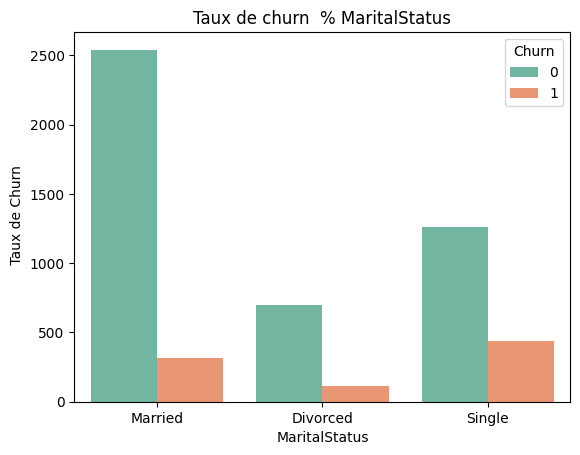

In [ ]:
sn.countplot(x='MaritalStatus',hue='Churn',data=df,palette='Set2')
plt.title("Taux de churn  % MaritalStatus")
plt.ylabel(" Taux de Churn")
# 1 Churn , 0 Non Churn
print( ' taux de churn des celibataire :', round(435 / 1264 * 100, 2),'%')
print( ' taux de churn des mariés :', round(316 / 2540 * 100, 2), '%')
print( ' taux de churn des divorcé :', round(116 / 695 * 100,2),'%')

Les personnes mariées constituent le segment de clientèle le plus important de l'entreprise.  Les clients célibataires ont le taux de churn le plus élevé suivis des clients mariés ,L'entreprise devrait envisager de prendre soin des produits qui conviennent aux clients célibataires.

# Quel niveau de ville a le nombre de commande et l'anciennetée la plus élevé ?

In [ ]:
df_grouped_tenure = df.groupby('CityTier')['Tenure'].agg(['mean', 'max'])
df_grouped_tenure

,mean,max
CityTier,,
1,10.528818,51.0
2,11.169725,31.0
3,9.361740,61.0


La ville de niveau 2 a le taux d'ancienneté le plus élevé, mais le taux d'ancienneté ne semble pas être un facteur déterminant.

In [ ]:
df_grouped_OrderCount = df.groupby('CityTier')['OrderCount'].agg(['mean', 'max'])
df_grouped_OrderCount

,mean,max
CityTier,,
1,3.042540,16.0
2,2.742991,13.0
3,3.232065,16.0


La ville de niveau 3 a la moyenne de commandes la plus élevée, mais cela ne semble pas être un facteur déterminant dans la résiliation des clients

# Est-ce que les clients ayant un score de satisfaction élevé passent beaucoup de temps sur l'application ?

**Y a-t-il une corrélation entre le score de satisfaction et le temps passé sur l'application ?**

In [ ]:
fig = px.histogram(df2, x="HourSpendOnApp", y="SatisfactionScore", orientation="h", color="Churn" ,
                   text_auto= True , title="<b>"+"Heures passées sur l'App Vs Score de satisfaction" ,
                   color_discrete_sequence = ['#BA1F33','#3A506B','#3E885B'])

fig.update_layout(hovermode='x',title_font_size=30)
fig.update_layout(
title_font_color="black",
template="plotly",
title_font_size=30,
hoverlabel_font_size=20,
title_x=0.5,
xaxis_title='HourSpendOnApp',
yaxis_title='SatisfactionScore',
)
fig.show()

Comme nous pouvons le constater, les personnes ayant un score de satisfaction plus faible passent moins de temps sur l'application que celles ayant un score de satisfaction de 5. Cependant, On ne peut pas affirmer  qu'il y ait une réelle relation entre le score de satisfaction et le temps passé par les personnes sur l'application

# Quel CityTier a le temps passé sur l'application le plus élevé ?

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning:



`distplot` is a dep

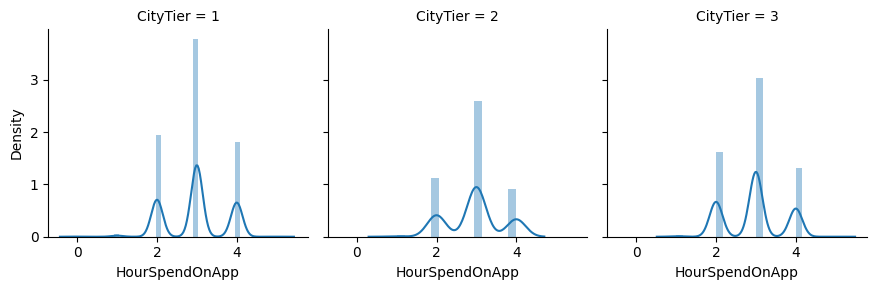

In [ ]:
g = sn.FacetGrid(df, col='CityTier')
g.map(sn.distplot, 'HourSpendOnApp')

La ville de niveau 1 a passé le plus grand nombre d'heures sur l'application.

# Quelle est la relation entre les réclamations (Complain) et les jours depuis la dernière commande (DaySinceLastOrder) ?

In [ ]:
df[['DaySinceLastOrder', 'Complain']].corr()

,DaySinceLastOrder,Complain
DaySinceLastOrder,1.000000,-0.051588
Complain,-0.051588,1.000000


Il y a une relation négative faible entre les réclamations et le nombre de jours depuis la dernière commande.

# Y a-t-il une relation entre le périphérique de connexion préféré (PreferredLoginDevice) et la résiliation (churn) ?

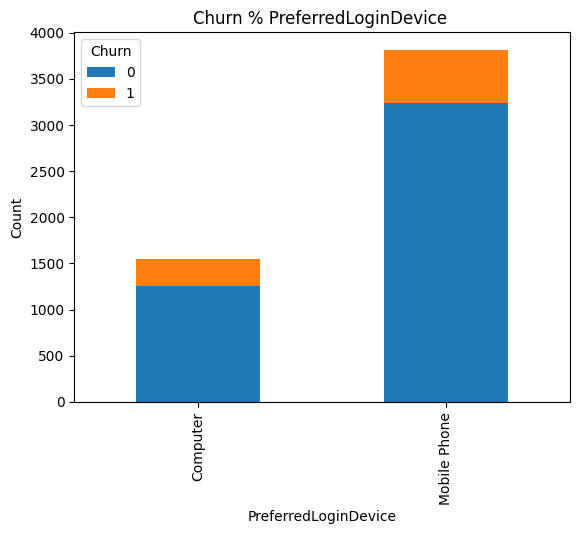

In [ ]:
grouped_data = df.groupby(['PreferredLoginDevice', 'Churn']).size().unstack().plot(kind='bar', stacked=True)


plt.title('Churn % PreferredLoginDevice ')
plt.xlabel('PreferredLoginDevice')
plt.ylabel('Count')

plt.show()

mobile phone users are likely to churn may be this indicates a problem on the app user experience on the app mobile version